In [1]:
import pandas as pd
import os, re 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import seaborn as sns 

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA
from numpy.linalg import svd 

#PERMANOVA on SV1/SV2 sample projections of data 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [28]:
SVD_base_dir = "/Users/evanlee/MSTP/Gordon/experiments/MG00_HWDC_og/HOSVD"
gsea_output_dir = "{0}/DE/gsea_output/cecal".format(SVD_base_dir)
figures_dir = "{0}/DE/gsea_figures".format(SVD_base_dir)
os.makedirs(figures_dir,exist_ok=True)

In [24]:
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
CAZYME_STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Bli463","Blu","Bwe","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Mmu","Pco","Pst",
                  "Rgn","Rob","Rto","Sga","Spa"]
STRAIN_TAXA_NAMES = ["B. breve","B. catenulatum","B. longum infantis 2D9","B. luti","B. obeum","D. formicigenerans",
                     "D. longicatena","E. avium","E. coli","F. prausnitzii","L. garvieae","L. ruminis",
                     "M. multacida","P. copri","P. stercorea","R. gnavus","R. torques","S. gallolyticus","S. pasteurianus"]
ABBREVS_TO_FULL = dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES))
FILTERING_DROPPED_STRAINS = ["Bli2D9","Pco","Pst","Blu","FprB"]
Ara_strains = ["Rob","Mmu","Bca","Eco"]

DE_phts = ["Ara","Xyl","Glu","Gln","Leu","Ile","Val","Acetate"]

,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,sig
0,B12,0.000371,0.014457,0.498493,-0.385104,-2.391752,25,NaN,True
4,Srl,0.003426,0.036318,0.431708,-0.742138,-2.112902,5,NaN,True
5,B9,0.004752,0.037587,0.407018,-0.483974,-2.053436,11,NaN,True
8,His,0.023782,0.133743,0.352488,-0.396160,-1.769669,12,NaN,False
11,Leu,0.054790,0.225532,0.321776,-0.287395,-1.537758,18,NaN,False
16,Chor,0.128472,0.400531,0.234393,-0.335463,-1.338847,10,NaN,False
22,Met,0.259928,0.583398,0.164406,-0.260043,-1.161627,12,NaN,False
24,Xlt,0.273038,0.583398,0.155242,-0.299574,-1.144245,9,NaN,False
21,Ino,0.286195,0.583398,0.150170,-0.340836,-1.138453,7,NaN,False
33,Trp,0.357746,0.630778,0.119888,-0.484375,-1.072551,3,NaN,False


,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,sig
2,Gal,0.005207,0.049468,0.407018,-0.753425,-1.781801,6,NaN,True
3,Lac,0.005207,0.049468,0.407018,-0.753425,-1.781801,6,NaN,True
5,Ino,0.075807,0.463415,0.287805,-0.418440,-1.200857,11,NaN,False
15,Cys,0.540785,0.879630,0.097877,-0.566667,-0.949030,2,NaN,False
21,Scr,0.555556,0.879630,0.118288,-0.489933,-0.941318,3,NaN,False
26,B2,0.729323,0.946718,0.139600,-0.394558,-0.858149,5,NaN,False
35,Man,0.974416,0.974416,0.017234,0.340185,0.608826,6,NaN,False
37,Thr,0.967431,0.974416,0.022727,0.385135,0.629879,4,NaN,False
36,Srl,0.945022,0.974416,0.034566,0.466667,0.672099,2,NaN,False
31,His,0.888377,0.964524,0.024849,0.438449,0.752160,5,NaN,False


,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,sig
5,B6,0.011588,0.079185,0.380730,-0.844749,-1.795829,5,NaN,False
7,B3,0.022111,0.100728,0.352488,-0.712948,-1.687014,7,NaN,False
8,aAOS,0.017789,0.100728,0.352488,-0.594753,-1.672141,12,NaN,False
9,Trp,0.060247,0.247015,0.321776,-0.710148,-1.582813,6,NaN,False
15,Pro,0.179293,0.489208,0.165657,-0.766873,-1.333553,3,NaN,False
18,B9,0.235849,0.502830,0.160801,-0.589041,-1.252227,5,NaN,False
19,Gln,0.245283,0.502830,0.157403,-0.584763,-1.243132,5,NaN,False
20,Asn,0.267677,0.522607,0.132846,-0.710003,-1.234659,3,NaN,False
21,His,0.284404,0.530025,0.178220,-0.451163,-1.120448,9,NaN,False
25,Gly,0.435484,0.675126,0.094665,-0.685715,-1.052445,2,NaN,False


,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,sig
0,Rha,0.000005,0.000222,0.610527,-0.980000,-1.867737,6,NaN,True
4,B1,0.001410,0.024247,0.455060,-0.818200,-1.867156,13,NaN,True
2,(Mal)n,0.002921,0.024247,0.431708,-0.736125,-1.832974,19,NaN,True
8,Mal,0.002921,0.024247,0.431708,-0.736125,-1.832974,19,NaN,True
3,Arg,0.002404,0.024247,0.431708,-0.774800,-1.804690,15,NaN,True
...,...,...,...,...,...,...,...,...,...
9,ddGlcA,0.002136,0.024247,0.431708,0.829001,1.721170,8,NaN,True
11,NANA,0.003861,0.026705,0.431708,0.711689,1.722745,14,NaN,True
5,GalA,0.002033,0.024247,0.431708,0.737246,1.784610,14,NaN,True
6,GlcA,0.002033,0.024247,0.431708,0.737246,1.784610,14,NaN,True


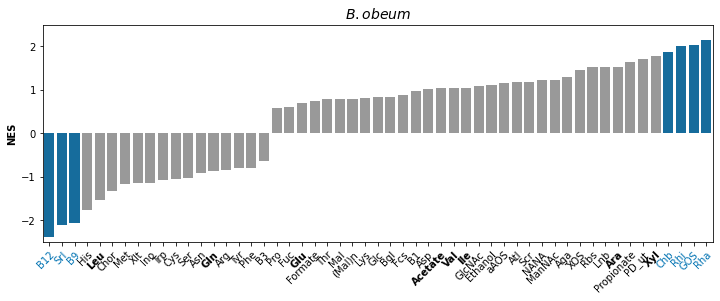

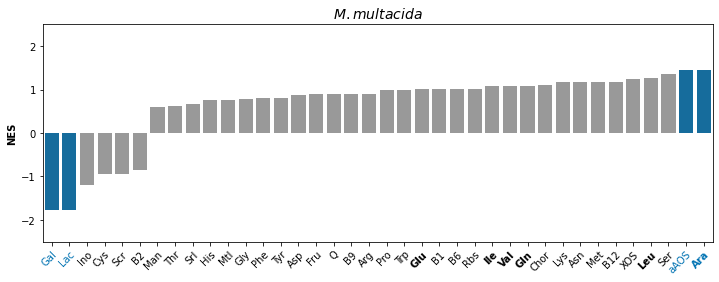

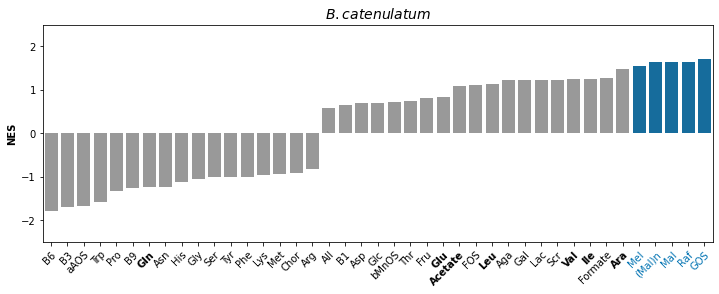

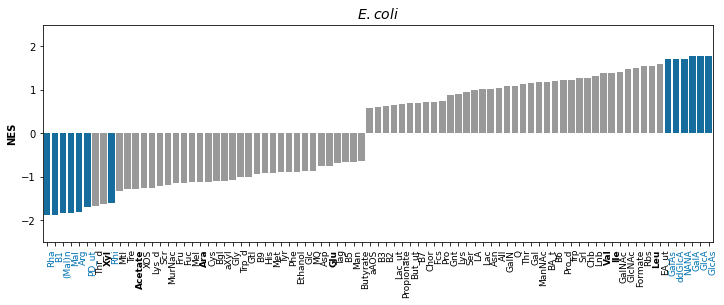

In [57]:
# for strain in STRAIN_ABBREVS[:1]: #Edit slice when done 
gsea_palette = {0:"#999999",1:"#0072B2"}
for strain in Ara_strains:
    if strain in FILTERING_DROPPED_STRAINS: #Arm-different strains and strains which had all loci filtered out  
        continue
    fgsea_all_fpath = "{0}/{1}_cecal_p1Cn2B_fgsea.csv".format(gsea_output_dir,strain)
    fgsea_res = pd.read_csv(fgsea_all_fpath)
    fgsea_res.sort_values(by=["NES"],inplace=True)
    fgsea_res.loc[:,"sig"] = fgsea_res.loc[:,"padj"] <= 0.05
    display(fgsea_res)
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    sns.barplot(data=fgsea_res,x="pathway",y="NES",hue="sig",palette=gsea_palette,dodge=False)
    ax.set_ylim(-2.5,2.5)
    ax_xticklabels = ax.get_xticklabels()
    pathways = list(fgsea_res["pathway"].values)
#     formatted_xtick = [r'\textbf{0}'.format(xtick) if xtick in DE_phts else xtick for xtick in all_xtick]
#     formatted_xtick = ['$\bf{0}$'.format(xtick) if xtick in DE_phts else xtick for xtick in all_xtick]
    if strain == "Eco":
        ax.set_xticklabels(labels=pathways,rotation=90,size=9,ha='right', rotation_mode='anchor')
    else:
        ax.set_xticklabels(labels=pathways,rotation=45,size=10,ha='right', rotation_mode='anchor')
    for pht in DE_phts:
        if pht in pathways:
            ax_xticklabels[pathways.index(pht)].set_weight("bold")
    sig_phts = fgsea_res.loc[fgsea_res["sig"]==True,"pathway"]
    for pht in sig_phts:
        ax_xticklabels[pathways.index(pht)].set_color("#0072B2")
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_title("$\it{0}$".format(ABBREVS_TO_FULL[strain]),size=14,fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(),weight="bold")
    gsea_bar_fpath = "{0}/{1}_gsea_res.pdf".format(figures_dir,strain)
    plt.savefig(gsea_bar_fpath,dpi=300,facecolor="w",bbox_inches="tight")
#     filt_xtick = []
        
        